This notebook provides the plotting functions for Figure 6 a-d. This includes the incorporation of stimulus parameters into the Gaussian Process model, the iterative selection of the kernels and the likelihood ratio tests.

In [1]:
%matplotlib inline

import GPy
import h5py
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import chisqprob
import seaborn as sns

from util.load_hdf5 import *
from util.zscore import *
from util.compute_bounds import *
from util.fill_bounds import *

sns.set_style('ticks')

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
 /usr/local/lib/python3.4/dist-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


In [2]:
directories = json.load(open('directories.json'))

off_chirp = load_hdf5(directories['data'] + 'SMP_M1_RR2_IPL2OFF_ChirpI.h5')
off_chirp_df = pd.read_csv(directories['data'] + 'SMP_M1_RR2_IPL2OFF_ChirpI.csv', index_col = 0)
# off_chirp_df = off_chirp_df.groupby(['roi', 'frame']).mean().reset_index()

off_sine = load_hdf5(directories['data'] + 'SMP_M1_RR2_IPL2OFF_Sine.h5')
off_sine_df = pd.read_csv(directories['data'] + 'SMP_M1_RR2_IPL2OFF_Sine.csv', index_col = 0)
off_sine_df = off_sine_df.groupby(['roi', 'frame']).mean().reset_index()

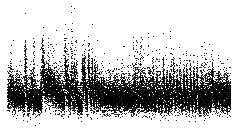

In [3]:
sns.set_style('white')

target_roi = 17
traces = off_chirp_df.loc[off_chirp_df['roi'] == target_roi, 'y']
tpnts  = off_chirp_df.loc[off_chirp_df['roi'] == target_roi, 'x_t']
tpnts_warp = off_chirp_df.loc[off_chirp_df['roi'] == target_roi, 'x_t_warped']

stimulus_duration = 66

stimulus_mask = tpnts > (stimulus_duration / 2)
traces  = traces[stimulus_mask]
tpnts  = tpnts[stimulus_mask]
tpnts_warp = tpnts_warp[stimulus_mask]
tpnts -= stimulus_duration / 2

fig, ax = plt.subplots(1)

ax.scatter(tpnts, traces, color = 'k', s = 0.5)

ax.set_xlim(0, stimulus_duration / 2);
ax.set_ylim(traces.min(), traces.max())
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_xlabel('', fontsize=10)
ax.set_xticklabels([]);
ax.set_yticklabels([]);
sns.despine(left = True, bottom = True, ax = ax)
ax.set_aspect(2)

fig.set_size_inches(4, 2.5)

In [4]:
m = GPy.models.SparseGPRegression(
    tpnts_warp[:, None],
    traces[:, None],
    num_inducing = 300,
    kernel = GPy.kern.RBF(1)
)

m.optimize_restarts(1, messages = True, max_iters = 20)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    09s19  06   2.836157e+04   1.441822e+06 
    31s64  19   2.727104e+04   1.216646e+06 
    37s12  22   2.703828e+04   1.866542e+05 
Runtime:     37s12
Optimization status: Maximum number of f evaluations reached

Optimization restart 1/1, f = 27038.280514563718


In [5]:
from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression()
stimulus_mask = off_chirp_df['x_t'] > 33
iso_reg.fit(off_chirp_df['x_t_warped'][stimulus_mask], off_chirp_df['x_t'][stimulus_mask])

n_tpnts = 32 * 20
x_new = np.linspace(off_chirp_df['x_t'].min(), off_chirp_df['x_t'].max() / 2, n_tpnts)
x_new_unwarp = iso_reg.transform(x_new)

mu, sig = m.predict(x_new[:, None], include_likelihood = False)
_, sig_outer = m.predict(x_new[:, None], include_likelihood = True)

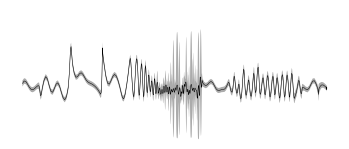

In [6]:
sns.set_style('white')

fig, ax = plt.subplots(1)

ax.plot(x_new_unwarp, mu, color = 'k', linewidth = 0.5)

upper, lower = compute_bounds(mu, sig, n_sigma = 3)
ax.fill_between(x_new_unwarp, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.33)

# ax.set_xlim(0, 32)
plt.tick_params(axis='both', which='major', labelsize='small')
ax.set_yticklabels([]);
ax.set_xticklabels([]);
ax.set_ylim(-3, 4)
ax.set_aspect(2)
sns.despine(left = True, bottom = True, ax = ax)

# fig.set_size_inches(4, 1.5)

In [7]:
sine_conditions = pd.read_csv(directories['misc'] + 'sine_conditions_2.csv', header = None)

sine_conditions.columns = ["shape", "frequency", "contrast"]

sine_conditions['trial'] = np.arange(len(sine_conditions))

off_sine_df = sine_conditions.merge(off_sine_df)

In [8]:
stimulation_start = off_sine_df['t'].min()

roi_df = off_sine_df.loc[off_sine_df['roi'] == target_roi, :]

x = roi_df['t']
y = roi_df['y']

In [9]:
stimulus = []
temporal_freq = 50

for itx, row in sine_conditions.iterrows():
    if row['shape'] != 0:
        stimulus.append(np.sin(np.linspace(0, 2 * np.pi, temporal_freq) * row['frequency']) * row['contrast'])
    else:
        stimulus.append(np.ones(temporal_freq) * np.nan)
        
sine_stimulus = np.hstack(stimulus)
sine_stimulus /= np.nanmax(sine_stimulus)
sine_tpnts = np.linspace(0, len(sine_conditions), len(sine_conditions) * temporal_freq) + stimulation_start

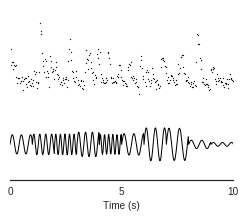

In [10]:
fig, ax = plt.subplots(1)

stimulus_offset = -4
ax.plot(sine_tpnts, sine_stimulus + stimulus_offset, linewidth = 1, color = 'k')

# ax.plot(x, y, linewidth = 0.5, color = 'k')
stimulus_delay = 0
ax.scatter(x - stimulus_delay, y, s = 1, color = 'k', marker = 'o')

start = stimulation_start
ax.set_xlim(start, start + 10)
ax.get_yaxis().set_visible(False)
plt.xticks([start, start + 5, start + 10])
ax.set_xticklabels([0, 5, 10])
sns.despine(left = True, ax = ax, offset = 10)
ax.set_xlabel('Time (s)', fontsize = 10);
plt.tick_params(axis='both', which='major', labelsize = 'medium')

fig.set_size_inches(4, 3)

# plt.savefig(directories['figs'] + 'hierarchical/' + 'roi_mean_traces.png', **fig_p)

In [11]:
shape_bool = off_sine_df['shape'] == 1
roi_bool = off_sine_df['roi'] == target_roi
roi_df = off_sine_df.loc[shape_bool & roi_bool, :]

In [12]:
trial_duration = np.mean(np.diff(off_sine['Triggertimes']))
roi_df['x_t'] = (roi_df['t'] - stimulus_delay) % trial_duration
roi_df['phase'] = (roi_df['x_t'] * 2 * np.pi * roi_df['frequency']) % (2 * np.pi)

x_cos = np.cos(roi_df['phase'].values)[:, None]
x_sin = np.sin(roi_df['phase'].values)[:, None]
x_frequency = roi_df['frequency'].values[:, None]
x_contrast = roi_df['contrast'].values[:, None]

X = np.concatenate([x_cos, x_sin, x_frequency, x_contrast], axis = 1)

y = roi_df['y'][:, None]

 /usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 /usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
k1 = GPy.kern.RBF(4, ARD = False, active_dims = [0, 1, 2, 3]) \
    + GPy.kern.RBF(3, ARD = False, active_dims = [0, 1, 3]) \
    + GPy.kern.RBF(3, ARD = False, active_dims = [0, 1, 2]) \
    + GPy.kern.RBF(2, ARD = False, active_dims = [0, 1]) \
    + GPy.kern.RBF(1, ARD = False, active_dims = [2,]) \
    + GPy.kern.RBF(1, ARD = False, active_dims = [3,])

In [14]:
m1 = GPy.models.SparseGPRegression(
        X,
        y,
        num_inducing = 500,
        kernel = k1
    )

In [15]:
m1.optimize_restarts(4, messages = True, max_iters = 25)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    03s05  04   9.923286e+02   2.871634e+03 
    12s02  16   8.845016e+02   3.566920e+00 
    17s87  24   8.791800e+02   4.104598e-01 
    20s14  27   8.791764e+02   3.378237e-02 
Runtime:     20s14
Optimization status: Maximum number of f evaluations reached

Optimization restart 1/4, f = 879.1764180666034
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    08s64  12   9.479183e+02   5.023834e+02 
    12s96  18   9.292935e+02   1.849631e+01 
    20s11  28   9.237528e+02   9.429911e+01 
Runtime:     20s11
Optimization status: Maximum number of f evaluations reached

Optimization restart 2/4, f = 923.7527683227752
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i    f              |g|        
    01s47  02   5.210920e+03   1.220303e+07 
    05s74  08   1.504359e+03   1.269646e+04 
    08s61  12   9.548835e+02   2.870716e+02 
    11s52  16   9.3616

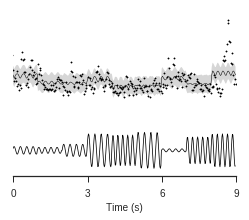

In [16]:
post_mu, post_sig = m1.predict(X, include_likelihood = False)

sns.set_style('ticks')

fig, ax = plt.subplots(1)

x_t = roi_df['t']
ax.scatter(x_t, roi_df['y'], s = 2, color = 'k', marker = 'o')
ax.plot(x_t, post_mu, linewidth = 0.5, color = 'k')

upper, lower = compute_bounds(post_mu, post_sig, n_sigma = 3)
ax.fill_between(x_t, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.16)

stimulus_offset = -4
ax.plot(sine_tpnts, sine_stimulus + stimulus_offset, linewidth = 0.75, color = 'k')

ax.get_yaxis().set_visible(False)
plt.xlim(32, 41)
plt.xticks(np.arange(0, 12, 3) + 32)
ax.set_xticklabels(np.arange(0, 12, 3))
ax.set_xlabel('Time (s)', fontsize = 10)

sns.despine(left = True, ax = ax)

fig.set_size_inches(4, 3)

In [17]:
X = np.concatenate([x_cos, x_sin, x_frequency, x_contrast], axis = 1)

y = roi_df['y'][:, None]

k1 = GPy.kern.RBF(4, ARD = False, active_dims = [0, 1, 2, 3]) \
    + GPy.kern.RBF(3, ARD = False, active_dims = [0, 1, 3]) \
    + GPy.kern.RBF(3, ARD = False, active_dims = [0, 1, 2]) \
    + GPy.kern.RBF(2, ARD = False, active_dims = [0, 1]) \
    + GPy.kern.RBF(1, ARD = False, active_dims = [2,]) \
    + GPy.kern.RBF(1, ARD = False, active_dims = [3,])

In [18]:
optimize_p = {
    'messages': False,
    'max_iters': 20,
}

n_repeats = 3
inc_lik = False

kernel_alpha = GPy.kern.RBF(2, ARD = False, active_dims = [0, 1]) # Time
kernel_beta = GPy.kern.RBF(1, ARD = False, active_dims = [2,]) # Frequency
kernel_gamma = GPy.kern.RBF(1, ARD = False, active_dims = [3,]) # Contrast
kernel_delta = GPy.kern.RBF(3, ARD = False, active_dims = [0, 1, 2]) # Time-Contrast
kernel_epsilon = GPy.kern.RBF(3, ARD = False, active_dims = [0, 1, 3]) # Time-Frequency
kernel_zeta = GPy.kern.RBF(2, ARD = False, active_dims = [1, 2]) # Contrast-Frequency
kernel_eta = GPy.kern.RBF(4, ARD = False, active_dims = [0, 1, 2, 3]) # Time-Contrast-Frequency

kernels = [kernel_alpha, kernel_beta, kernel_gamma, kernel_delta, kernel_epsilon, kernel_zeta, kernel_eta]

In [34]:
gp_1 = GPy.models.GPRegression(X, y, kernel = kernel_alpha)
gp_1.optimize_restarts(n_repeats, **optimize_p)

gp_2 = GPy.models.GPRegression(X, y, kernel = kernel_beta)
gp_2.optimize_restarts(n_repeats, **optimize_p)

gp_3 = GPy.models.GPRegression(X, y, kernel = kernel_gamma)
gp_3.optimize_restarts(n_repeats, **optimize_p)

gp_4 = GPy.models.GPRegression(X, y, kernel = kernel_delta)
gp_4.optimize_restarts(n_repeats, **optimize_p)

gp_5 = GPy.models.GPRegression(X, y, kernel = kernel_epsilon)
gp_5.optimize_restarts(n_repeats, **optimize_p)

gp_6 = GPy.models.GPRegression(X, y, kernel = kernel_zeta)
gp_6.optimize_restarts(n_repeats, **optimize_p)

gp_7 = GPy.models.GPRegression(X, y, kernel = kernel_eta)
gp_7.optimize_restarts(n_repeats, **optimize_p)

log_likelihoods_1 = np.asarray([gp_.log_likelihood() for gp_ in [gp_1, gp_2, gp_3, gp_4, gp_5, gp_6, gp_7]])
pass_1_max = log_likelihoods_1.argmax()
pass_1_max

 /usr/local/lib/python3.4/dist-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 2 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


Optimization restart 1/3, f = 930.8073189480695
Optimization restart 2/3, f = 930.8175868273661
Optimization restart 3/3, f = 930.9280741378865


 /usr/local/lib/python3.4/dist-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


Optimization restart 1/3, f = 918.5029269671561
Optimization restart 2/3, f = 918.520827922711
Optimization restart 3/3, f = 918.7042216199184
Optimization restart 1/3, f = 906.411443211073
Optimization restart 2/3, f = 906.4113247956942
Optimization restart 3/3, f = 906.4114724803051


 /usr/local/lib/python3.4/dist-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 3 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


Optimization restart 1/3, f = 929.7521666257467
Optimization restart 2/3, f = 930.539129115811
Optimization restart 3/3, f = 929.7524005716637
Optimization restart 1/3, f = 897.0811451436048
Optimization restart 2/3, f = 897.0811451495526
Optimization restart 3/3, f = 897.0811631515453
Optimization restart 1/3, f = 931.4712150161305
Optimization restart 2/3, f = 933.7162750720656
Optimization restart 3/3, f = 933.512590979303
Optimization restart 1/3, f = 879.5631816031766
Optimization restart 2/3, f = 879.563181602884
Optimization restart 3/3, f = 945.9604313790153


6

In [35]:
messages = False
pass_2_kernels = kernels[:]
pass_2_kernels = np.delete(pass_2_kernels, pass_1_max)

gp_8 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[0])
gp_8.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

gp_9 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[1])
gp_9.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

gp_10 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[2])
gp_10.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

gp_11 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[3])
gp_11.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

gp_12 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[4])
gp_12.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

gp_13 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[5])
gp_13.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

log_likelihoods_2 = np.asarray([gp_.log_likelihood() for gp_ in [gp_8, gp_9, gp_10, gp_11, gp_12, gp_13]])
pass_2_max = log_likelihoods_2.argmax()
pass_2_max

Optimization restart 1/3, f = 878.763422696672
Optimization restart 2/3, f = 878.7919759073072
Optimization restart 3/3, f = 878.8126799015289
Optimization restart 1/3, f = 878.4922970444032
Optimization restart 2/3, f = 878.5394114590367
Optimization restart 3/3, f = 878.6735329929174
Optimization restart 1/3, f = 879.5355321972941
Optimization restart 2/3, f = 879.5378228618332
Optimization restart 3/3, f = 879.5452005771791
Optimization restart 1/3, f = 879.1566957820523
Optimization restart 2/3, f = 879.169711074884
Optimization restart 3/3, f = 879.1539281443056
Optimization restart 1/3, f = 879.5662112159789
Optimization restart 2/3, f = 880.0314183324801
Optimization restart 3/3, f = 879.5696226164464
Optimization restart 1/3, f = 879.335117432219
Optimization restart 2/3, f = 879.195800192934
Optimization restart 3/3, f = 879.196589621763


1

In [21]:
messages = False
pass_3_kernels = pass_2_kernels[:]
pass_3_kernels = np.delete(pass_3_kernels, pass_2_max)

gp_14 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[0])
gp_14.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

gp_15 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[1])
gp_15.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

gp_16 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[2])
gp_16.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

gp_17 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[3])
gp_17.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

gp_18 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[4])
gp_18.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

log_likelihoods_3 = np.asarray([gp_.log_likelihood() for gp_ in [gp_14, gp_15, gp_16, gp_17, gp_18]])
pass_3_max = log_likelihoods_3.argmax()
pass_3_max

Optimization restart 1/3, f = 877.8790246044746
Optimization restart 2/3, f = 878.4305817808593
Optimization restart 3/3, f = 879.3004873248167
Optimization restart 1/3, f = 878.5565969150384
Optimization restart 2/3, f = 878.5985700367636
Optimization restart 3/3, f = 878.5452642277555
Optimization restart 1/3, f = 877.9425644407892
Optimization restart 2/3, f = 878.8953551148581
Optimization restart 3/3, f = 878.7445363279003
Optimization restart 1/3, f = 878.5701106799258
Optimization restart 2/3, f = 878.4982056479291
Optimization restart 3/3, f = 878.5618658693834
Optimization restart 1/3, f = 878.3888833588907
Optimization restart 2/3, f = 879.228688313154
Optimization restart 3/3, f = 879.2858953347613


0

In [22]:
messages = False
pass_4_kernels = pass_3_kernels[:]
pass_4_kernels = np.delete(pass_4_kernels, pass_3_max)

gp_19 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[pass_3_max] + pass_4_kernels[0])
gp_19.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

gp_20 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[pass_3_max] + pass_4_kernels[1])
gp_20.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

gp_21 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[pass_3_max] + pass_4_kernels[2])
gp_21.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

gp_22 = GPy.models.GPRegression(X, y, kernel = kernels[pass_1_max] + pass_2_kernels[pass_2_max] + pass_3_kernels[pass_3_max] + pass_4_kernels[3])
gp_22.optimize_restarts(n_repeats, messages = messages, max_iters = 20)

log_likelihoods_4 = np.asarray([gp_.log_likelihood() for gp_ in [gp_19, gp_20, gp_21, gp_22]])
pass_4_max = log_likelihoods_4.argmax()
pass_4_max

Optimization restart 1/3, f = 877.876443425719
Optimization restart 2/3, f = 879.849926895715
Optimization restart 3/3, f = 879.0107941595465
Optimization restart 1/3, f = 877.8761971246875
Optimization restart 2/3, f = 878.6760019734868
Optimization restart 3/3, f = 878.3983184451833
Optimization restart 1/3, f = 877.9473634368856
Optimization restart 2/3, f = 879.1065784827981
Optimization restart 3/3, f = 878.529955652851
Optimization restart 1/3, f = 877.9572596966852
Optimization restart 2/3, f = 879.1791988977602
Optimization restart 3/3, f = 878.585310127287


1

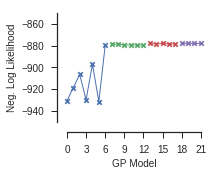

In [36]:
fig, ax = plt.subplots(1)

ax.plot(np.arange(0, 7, 1), log_likelihoods_1, linewidth = 1, label = 'Pass 1')
ax.scatter(np.arange(0, 7, 1), log_likelihoods_1, s = 20, clip_on = False, marker = 'x')

ax.plot(np.arange(0, 6, 1) + 7, log_likelihoods_2, linewidth = 1, label = 'Pass 2')
ax.scatter(np.arange(0, 6, 1) + 7, log_likelihoods_2, s = 20, clip_on = False, marker = 'x')

ax.plot(np.arange(0, 5, 1) + 13, log_likelihoods_3, linewidth = 1, label = 'Pass 3')
ax.scatter(np.arange(0, 5, 1) + 13, log_likelihoods_3, s = 20, clip_on = False, marker = 'x')

ax.plot(np.arange(0, 4, 1) + 18, log_likelihoods_4, linewidth = 1, label = 'Pass 4')
ax.scatter(np.arange(0, 4, 1) + 18, log_likelihoods_4, s = 20, clip_on = False, marker = 'x')

ax.set_xlim(0, 21)
plt.xticks(np.arange(0, 24, 3))
ax.set_ylim(-950, -850)
# plt.yticks(np.arange(-1000, -800, 100))

ax.set_xlabel('GP Model', fontsize = 10)
ax.set_ylabel('Neg. Log Likelihood', fontsize = 10)

# plt.legend()
sns.despine(ax = ax, offset = 10)

fig.set_size_inches(2.4, 2)

plt.savefig(directories['figs'] + 'oscillation/' + 'Iterative Kernel Selection.svg', dpi = 600)

In [24]:
likelihood_ratio = lambda LL_0, LL_1: 2 * (LL_1 - LL_0)

LL_0 = log_likelihoods_1[pass_1_max]
LL_1 = log_likelihoods_2[pass_2_max]
LL_2 = log_likelihoods_3[pass_3_max]
LL_3 = log_likelihoods_4[pass_4_max]

LLR = likelihood_ratio(LL_0, LL_1)
print(LLR)
p = chisqprob(LLR, 1) 
print('Second Pass (p): %.4f' % p)

LLR = likelihood_ratio(LL_1, LL_2)
print(LLR)
p = chisqprob(LLR, 1) 
print('Third Pass (p): %.4f' % p)

LLR = likelihood_ratio(LL_2, LL_3)
print(LLR)
p = chisqprob(LLR, 1) 
print('Fourth Pass (p): %.4f' % p)

2.14479814755
Second Pass (p): 0.1431
1.22351584928
Third Pass (p): 0.2687
0.00565495957426
Fourth Pass (p): 0.9401


In [25]:
# plt.plot(freq_tpnts, freq_mu, color = 'k', linewidth = 0.5)

In [37]:
stimulus = load_hdf5('/rogerson_et_al/misc/chirp.h5')['chirp']
stimulus_range = stimulus.max() - stimulus.min()
stimulus -= stimulus.min()
stimulus /= stimulus.max()

stimulus_time = np.linspace(0, 32, stimulus.shape[0])

sns.set_style('ticks')

tpnts = np.linspace(0, 8, 256) 

linewidth = 0.75
fig, ax = plt.subplots(1)

model_offset = 4

upper, lower = compute_bounds(freq_mu, freq_sig, n_sigma = 2)
ax.fill_between(freq_tpnts, upper[:, 0] + model_offset, lower[:, 0] + model_offset, facecolor = 'k', alpha = 0.33)
upper, lower = compute_bounds(cont_mu, cont_sig, n_sigma = 2)
ax.fill_between(cont_tpnts, upper[:, 0] + model_offset, lower[:, 0] + model_offset, facecolor = 'k', alpha = 0.33)
upper, lower = compute_bounds(mu, sig, n_sigma = 2)
ax.fill_between(x_new_unwarp - 33, upper[:, 0], lower[:, 0], facecolor = 'k', alpha = 0.33)

ax.plot(x_new_unwarp - 33, mu, color = 'k', linewidth = linewidth);

ax.plot(freq_tpnts, freq_mu + model_offset, color = 'k', linewidth = linewidth)
ax.plot(cont_tpnts, cont_mu + model_offset, color = 'k', linewidth = linewidth)

ax.plot(stimulus_time, stimulus - 4, color = 'k', linewidth = linewidth)

ax.set_xlim(0, 32)
plt.xticks(np.arange(0, 36, 4.0))
ax.set_xlabel('Time (s)', fontsize = 10)
ax.axes.get_yaxis().set_visible(False)
plt.tick_params(axis='both', which='major', labelsize='small')

sns.despine(left = True, ax = ax)

fig.set_size_inches(2.4, 2)

plt.savefig(directories['figs'] + 'oscillation/' + 'Chirp Prediction.svg', dpi = 600)

ValueError: Illegal slicing argument for scalar dataspace

In [ ]:
post_mu, post_sig = gp_17.predict(X, include_likelihood = False)

sns.set_style('ticks')

fig, ax = plt.subplots(1)

offset = 3
x_t = roi_df['t']

x_t_mask = (x_t > 32) & (x_t < 41) 
ax.scatter(x_t[x_t_mask], roi_df['y'][x_t_mask] + offset, s = 2, color = 'k', marker = 'o')
ax.plot(x_t[x_t_mask], post_mu[x_t_mask], linewidth = 0.5, color = 'k')

upper, lower = compute_bounds(post_mu, post_sig, n_sigma = 3)
ax.fill_between(x_t[x_t_mask], upper[x_t_mask, 0], lower[x_t_mask, 0], facecolor = 'k', alpha = 0.16)

stimulus_offset = -2.5
sine_mask = (sine_tpnts > 32) & (sine_tpnts < 41)  
ax.plot(sine_tpnts[sine_mask], sine_stimulus[sine_mask] - offset, linewidth = 0.75, color = 'k')

ax.get_yaxis().set_visible(False)
plt.xlim(32, 41)
plt.xticks(np.arange(0, 12, 3) + 32)
ax.set_xticklabels(np.arange(0, 12, 3))
ax.set_xlabel('Time (s)', fontsize = 10)

sns.despine(left = True, ax = ax)

fig.set_size_inches(2.4, 2.8)

plt.tight_layout()

plt.savefig(directories['figs'] + 'oscillation/' + 'Fitted Osc GP.svg', dpi = 600)

In [ ]:
i_freq = np.linspace(0, 8, 50)
i_cont = np.linspace(0, 100, 50)
n_freq = len(i_freq)
n_cont =  len(i_cont)
latent_uncertainty = np.zeros([n_freq, n_cont])

for itx, new_freq in enumerate(i_freq):
    for ity, new_cont in enumerate(i_cont):
            X_predict = np.concatenate([
                    np.cos(x_new_frequency),
                    np.sin(x_new_frequency),
                    new_freq * np.ones([1, x_new_frequency.shape[0]]).flatten(order = 'f')[:, None],
                    new_cont * np.ones([1, x_new_frequency.shape[0]]).flatten(order = 'f')[:, None] 
            ], axis = 1)

            latent_uncertainty[itx, ity] = np.sum(gp_17.predict(X_predict, include_likelihood = False)[1])

from skimage.feature import peak_local_max

n_peaks = 5

peaks = peak_local_max(latent_uncertainty[3:, 5:],  min_distance = 3) + 1
peaks_order = latent_uncertainty[3:, 5:][peaks[:, 0], peaks[:, 1]].argsort()

peaks = peaks[peaks_order, :].astype(float)[:, ::-1]

peaks[:, 0] = (peaks[:, 0] + 5) /  n_cont * 100
peaks[:, 1] = (peaks[:, 1] + 3) / n_freq * 8

peaks = peaks[-n_peaks:, :]

# plt.scatter(peaks[:, 0], peaks[:, 1], color = 'g', s = 20, marker = 'x', clip_on = False)

In [ ]:
fig, ax = plt.subplots(1)

cax = ax.imshow(latent_uncertainty, origin = 'lower', cmap = 'inferno_r', extent = (0, 100, 0, 8), 
                aspect = 100 / 8, vmin = 0, vmax = 80)

ax.scatter(x_contrast, x_frequency, color = 'k', s = 5, marker = 'o', clip_on = False, label = 'Sampled')
ax.scatter(peaks[:, 0], peaks[:, 1], color = 'k', s = 15, marker = 'x', clip_on = False, label = 'Proposed')

ax.plot(np.ones(100) * 10, np.linspace(0, 8, 100), color = 'k', alpha = 1, linestyle = ':', linewidth = 0.5)
ax.plot(np.linspace(0, 100, 100), np.ones(100), color = 'k', alpha = 1, linestyle = ':', linewidth = 0.5)

plt.xlim(0, 100)
plt.xticks(np.arange(0, 125, 25))
ax.set_xlabel('Contrast (%)', fontsize = 10)

plt.ylim(0, 8)
plt.yticks(np.arange(0, 10, 2), fontsize = 10)
ax.set_ylabel('Frequency (Hz)')

plt.tick_params(axis='both', which='major', labelsize='medium')
sns.despine(ax = ax, offset = 8)

fig.set_size_inches(3.4, 3.4)

cbar = fig.colorbar(cax, ax = ax, ticks=[0, np.round(np.max(latent_uncertainty), -2)], 
                    fraction=0.046, pad=0.04)
cbar.set_label('$\Sigma \sigma_{latent}$', labelpad= -25, y=0.5, fontsize = 10)

plt.legend(ncol = 2, bbox_to_anchor = (-0.1, 1.05, 1, 0), handletextpad = -0.25)

plt.tight_layout()

fig.set_size_inches(2.8, 2.8)

plt.savefig(directories['figs'] + 'oscillation/' + 'Parameter Space.svg', dpi = 600)